In [82]:
# # Deleting Folder
# import shutil
# shutil.rmtree("/kaggle/working/")

## Importing Libraries

In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Activation, add

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError



from tensorflow.keras import backend as K

sns.set_theme(style='darkgrid', palette='pastel')

## Generator to load images for segmentation task

Note 1: Loaded 2700 images from training data (300 images * 9 labels)

Note 2: Loaded 450 images from testing data (50 images * 9)

- Taken less images due to using 256 \* 256 \* 3 image size and less memory usage

In [84]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# Paths for train and test datasets
train_dir = "/kaggle/input/dermnet-and-skin-disease-9-classes/Merged Dataset/Train"
test_dir = "/kaggle/input/dermnet-and-skin-disease-9-classes/Merged Dataset/test"

# Temporary directories for filtered data
temp_train_dir = "/kaggle/working/temp_train"
temp_test_dir = "/kaggle/working/temp_test"

# Image size
IMG_SIZE = 256

# Function to copy only the first 25 images from each subfolder if not mentioned
def filter_images(source_dir, target_dir, max_images=25):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    for subfolder in os.listdir(source_dir):
        subfolder_path = os.path.join(source_dir, subfolder)
        target_subfolder_path = os.path.join(target_dir, subfolder)

        if os.path.isdir(subfolder_path):
            os.makedirs(target_subfolder_path, exist_ok=True)
            images = sorted(os.listdir(subfolder_path))[:max_images]

            for img in images:
                source_img_path = os.path.join(subfolder_path, img)
                target_img_path = os.path.join(target_subfolder_path, img)

                shutil.copy(source_img_path, target_img_path)

# Filter the images for train and test directories
filter_images(train_dir, temp_train_dir, max_images=300)
filter_images(test_dir, temp_test_dir, max_images=50)

# ImageDataGenerator to preprocess images
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values

# Train generator
train_generator = datagen.flow_from_directory(
    temp_train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode=None,  # No labels needed for segmentation step
    shuffle=False
)

# Test generator
test_generator = datagen.flow_from_directory(
    temp_test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

print(f"Total images in train generator: {len(train_generator.filenames)}")
print(f"Total images in test generator: {len(test_generator.filenames)}")

Found 2700 images belonging to 9 classes.
Found 450 images belonging to 9 classes.
Total images in train generator: 2700
Total images in test generator: 450


## Performing Segmentation on the loaded data

### Loss functions of Fuzzy Unet Architecture

In [85]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2 * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice, axis=0)

# Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IoU Metric
def iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score, axis=0)

### Defining the Fuzzy Unet Model

In [86]:
from tensorflow.keras.layers import Layer

class FuzzyAttention(Layer):
    def call(self, inputs, **kwargs):
        feature_map, attention_map = inputs
        return feature_map * attention_map


In [87]:
def fuzzy_unet(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    skip_connections = []

    # Encoder
    for filters in [64, 128, 256, 512]:
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        skip_connections.append(x)
        x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)

    # Bottleneck
    x = tf.keras.layers.Conv2D(1024, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(1024, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Decoder
    for filters in [512, 256, 128, 64]:
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        skip_connection = skip_connections.pop()
        attention = tf.keras.layers.Conv2D(filters, 1, padding='same', activation='sigmoid')(skip_connection)
        skip_connection = skip_connection * attention
        x = tf.keras.layers.add([x, skip_connection])

        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

### Loading the weights of already experimented Fuzzy Unet models

The fuzzy unet predefined model amd its wights were downloaded from another notebook

In [88]:
model = fuzzy_unet(input_shape=(256, 256, 3))
model.load_weights('/kaggle/input/fuzzy-u-net/keras/default/1/Skin_cancer_Segmentation.h5')

In [89]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Directory to save predicted masks
output_dir = "/kaggle/working/predicted_masks"
os.makedirs(output_dir, exist_ok=True)

def save_predictions(generator, model, output_dir, num_images):
    # Calculate the number of batches
    num_batches = int(np.ceil(num_images / generator.batch_size))
    
    for i in tqdm(range(num_batches), desc="Processing batches"):
        # Get a batch from the generator
        batch = next(generator)
        
        # Get predictions from the model
        predictions = model.predict(batch)  # Output shape: (batch_size, 256, 256, 1)
        predictions = (predictions > 0.5).astype(np.uint8)  # Binarize masks

        for j, pred in enumerate(predictions):
            index = i * generator.batch_size + j
            if index < num_images:
                # Extract subfolder and image names from generator filenames
                subfolder = generator.filenames[index].split(os.sep)[0]
                img_name = os.path.basename(generator.filenames[index])

                subfolder_path = os.path.join(output_dir, subfolder)
                os.makedirs(subfolder_path, exist_ok=True)

                output_path = os.path.join(subfolder_path, img_name)
                
                # Ensure pred shape is (256, 256, 1)
                pred = np.squeeze(pred, axis=-1)  # Remove last dimension if it exists (e.g., (256, 256, 1, 1) -> (256, 256, 1))
                pred = np.expand_dims(pred, axis=-1)  # Ensure final shape is (256, 256, 1)
                
                # Save the prediction as an image
                tf.keras.preprocessing.image.save_img(output_path, pred)

# Save predictions for train and test datasets
save_predictions(train_generator, model, os.path.join(output_dir, "train"), len(train_generator.filenames))
save_predictions(test_generator, model, os.path.join(output_dir, "test"), len(test_generator.filenames))


Processing batches:   0%|          | 0/85 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing batches:   1%|          | 1/85 [00:01<02:47,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:   2%|▏         | 2/85 [00:03<01:57,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:   4%|▎         | 3/85 [00:04<01:41,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:   5%|▍         | 4/85 [00:05<01:34,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing batches:   6%|▌         | 5/85 [00:06<01:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing batches:   7%|▋         | 6/85 [00:07<01:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:   8%|▊         | 7/85 [00:08<01:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing batches:   9%|▉         | 8/85 [00:09<01:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  11%|█         | 9/85 [00:10<01:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing batches:  12%|█▏        | 10/85 [00:11<01:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  13%|█▎        | 11/85 [00:12<01:16,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  14%|█▍        | 12/85 [00:13<01:14,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  15%|█▌        | 13/85 [00:14<01:13,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  16%|█▋        | 14/85 [00:15<01:11,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  18%|█▊        | 15/85 [00:16<01:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  19%|█▉        | 16/85 [00:17<01:09,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  20%|██        | 17/85 [00:18<01:07,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  21%|██        | 18/85 [00:19<01:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  22%|██▏       | 19/85 [00:20<01:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  24%|██▎       | 20/85 [00:21<01:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  25%|██▍       | 21/85 [00:21<01:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  26%|██▌       | 22/85 [00:22<00:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  27%|██▋       | 23/85 [00:23<00:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing batches:  28%|██▊       | 24/85 [00:24<00:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  29%|██▉       | 25/85 [00:25<00:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  31%|███       | 26/85 [00:26<00:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing batches:  32%|███▏      | 27/85 [00:27<00:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  33%|███▎      | 28/85 [00:28<00:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  34%|███▍      | 29/85 [00:29<00:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  35%|███▌      | 30/85 [00:30<00:49,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  36%|███▋      | 31/85 [00:31<00:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  38%|███▊      | 32/85 [00:32<00:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing batches:  39%|███▉      | 33/85 [00:32<00:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  40%|████      | 34/85 [00:33<00:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  41%|████      | 35/85 [00:34<00:44,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  42%|████▏     | 36/85 [00:35<00:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  44%|████▎     | 37/85 [00:36<00:41,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  45%|████▍     | 38/85 [00:37<00:40,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  46%|████▌     | 39/85 [00:38<00:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:  47%|████▋     | 40/85 [00:38<00:39,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  48%|████▊     | 41/85 [00:39<00:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  49%|████▉     | 42/85 [00:40<00:37,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  51%|█████     | 43/85 [00:41<00:36,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing batches:  52%|█████▏    | 44/85 [00:42<00:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  53%|█████▎    | 45/85 [00:43<00:34,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  54%|█████▍    | 46/85 [00:44<00:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  55%|█████▌    | 47/85 [00:44<00:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  56%|█████▋    | 48/85 [00:45<00:31,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  58%|█████▊    | 49/85 [00:46<00:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  59%|█████▉    | 50/85 [00:47<00:29,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing batches:  60%|██████    | 51/85 [00:48<00:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  61%|██████    | 52/85 [00:49<00:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  62%|██████▏   | 53/85 [00:49<00:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing batches:  64%|██████▎   | 54/85 [00:50<00:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  65%|██████▍   | 55/85 [00:51<00:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  66%|██████▌   | 56/85 [00:52<00:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  67%|██████▋   | 57/85 [00:53<00:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  68%|██████▊   | 58/85 [00:53<00:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  69%|██████▉   | 59/85 [00:54<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  71%|███████   | 60/85 [00:55<00:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  72%|███████▏  | 61/85 [00:56<00:19,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  73%|███████▎  | 62/85 [00:57<00:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  74%|███████▍  | 63/85 [00:57<00:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  75%|███████▌  | 64/85 [00:58<00:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  76%|███████▋  | 65/85 [00:59<00:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  78%|███████▊  | 66/85 [01:00<00:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:  79%|███████▉  | 67/85 [01:01<00:15,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  80%|████████  | 68/85 [01:02<00:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  81%|████████  | 69/85 [01:02<00:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  82%|████████▏ | 70/85 [01:03<00:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing batches:  84%|████████▎ | 71/85 [01:04<00:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  85%|████████▍ | 72/85 [01:05<00:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:  86%|████████▌ | 73/85 [01:06<00:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  87%|████████▋ | 74/85 [01:07<00:09,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  88%|████████▊ | 75/85 [01:08<00:08,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  89%|████████▉ | 76/85 [01:08<00:07,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  91%|█████████ | 77/85 [01:09<00:06,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  92%|█████████▏| 78/85 [01:10<00:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  93%|█████████▎| 79/85 [01:11<00:04,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  94%|█████████▍| 80/85 [01:12<00:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  95%|█████████▌| 81/85 [01:12<00:03,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  96%|█████████▋| 82/85 [01:13<00:02,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:  98%|█████████▊| 83/85 [01:14<00:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  99%|█████████▉| 84/85 [01:15<00:00,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


Processing batches:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:   7%|▋         | 1/15 [00:00<00:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing batches:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing batches:  20%|██        | 3/15 [00:02<00:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  27%|██▋       | 4/15 [00:03<00:10,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  33%|███▎      | 5/15 [00:04<00:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  40%|████      | 6/15 [00:05<00:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  47%|████▋     | 7/15 [00:06<00:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing batches:  53%|█████▎    | 8/15 [00:07<00:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  60%|██████    | 9/15 [00:08<00:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  67%|██████▋   | 10/15 [00:09<00:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  73%|███████▎  | 11/15 [00:10<00:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing batches:  80%|████████  | 12/15 [00:10<00:02,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing batches:  87%|████████▋ | 13/15 [00:11<00:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing batches:  93%|█████████▎| 14/15 [00:12<00:00,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Processing batches: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


## Visualizing images

- Image 1: Skin image (1 from each class/label)
- Image 2: Masks (generated by fuzzy unet)
- Image 3: Masked image (skin image + masks)

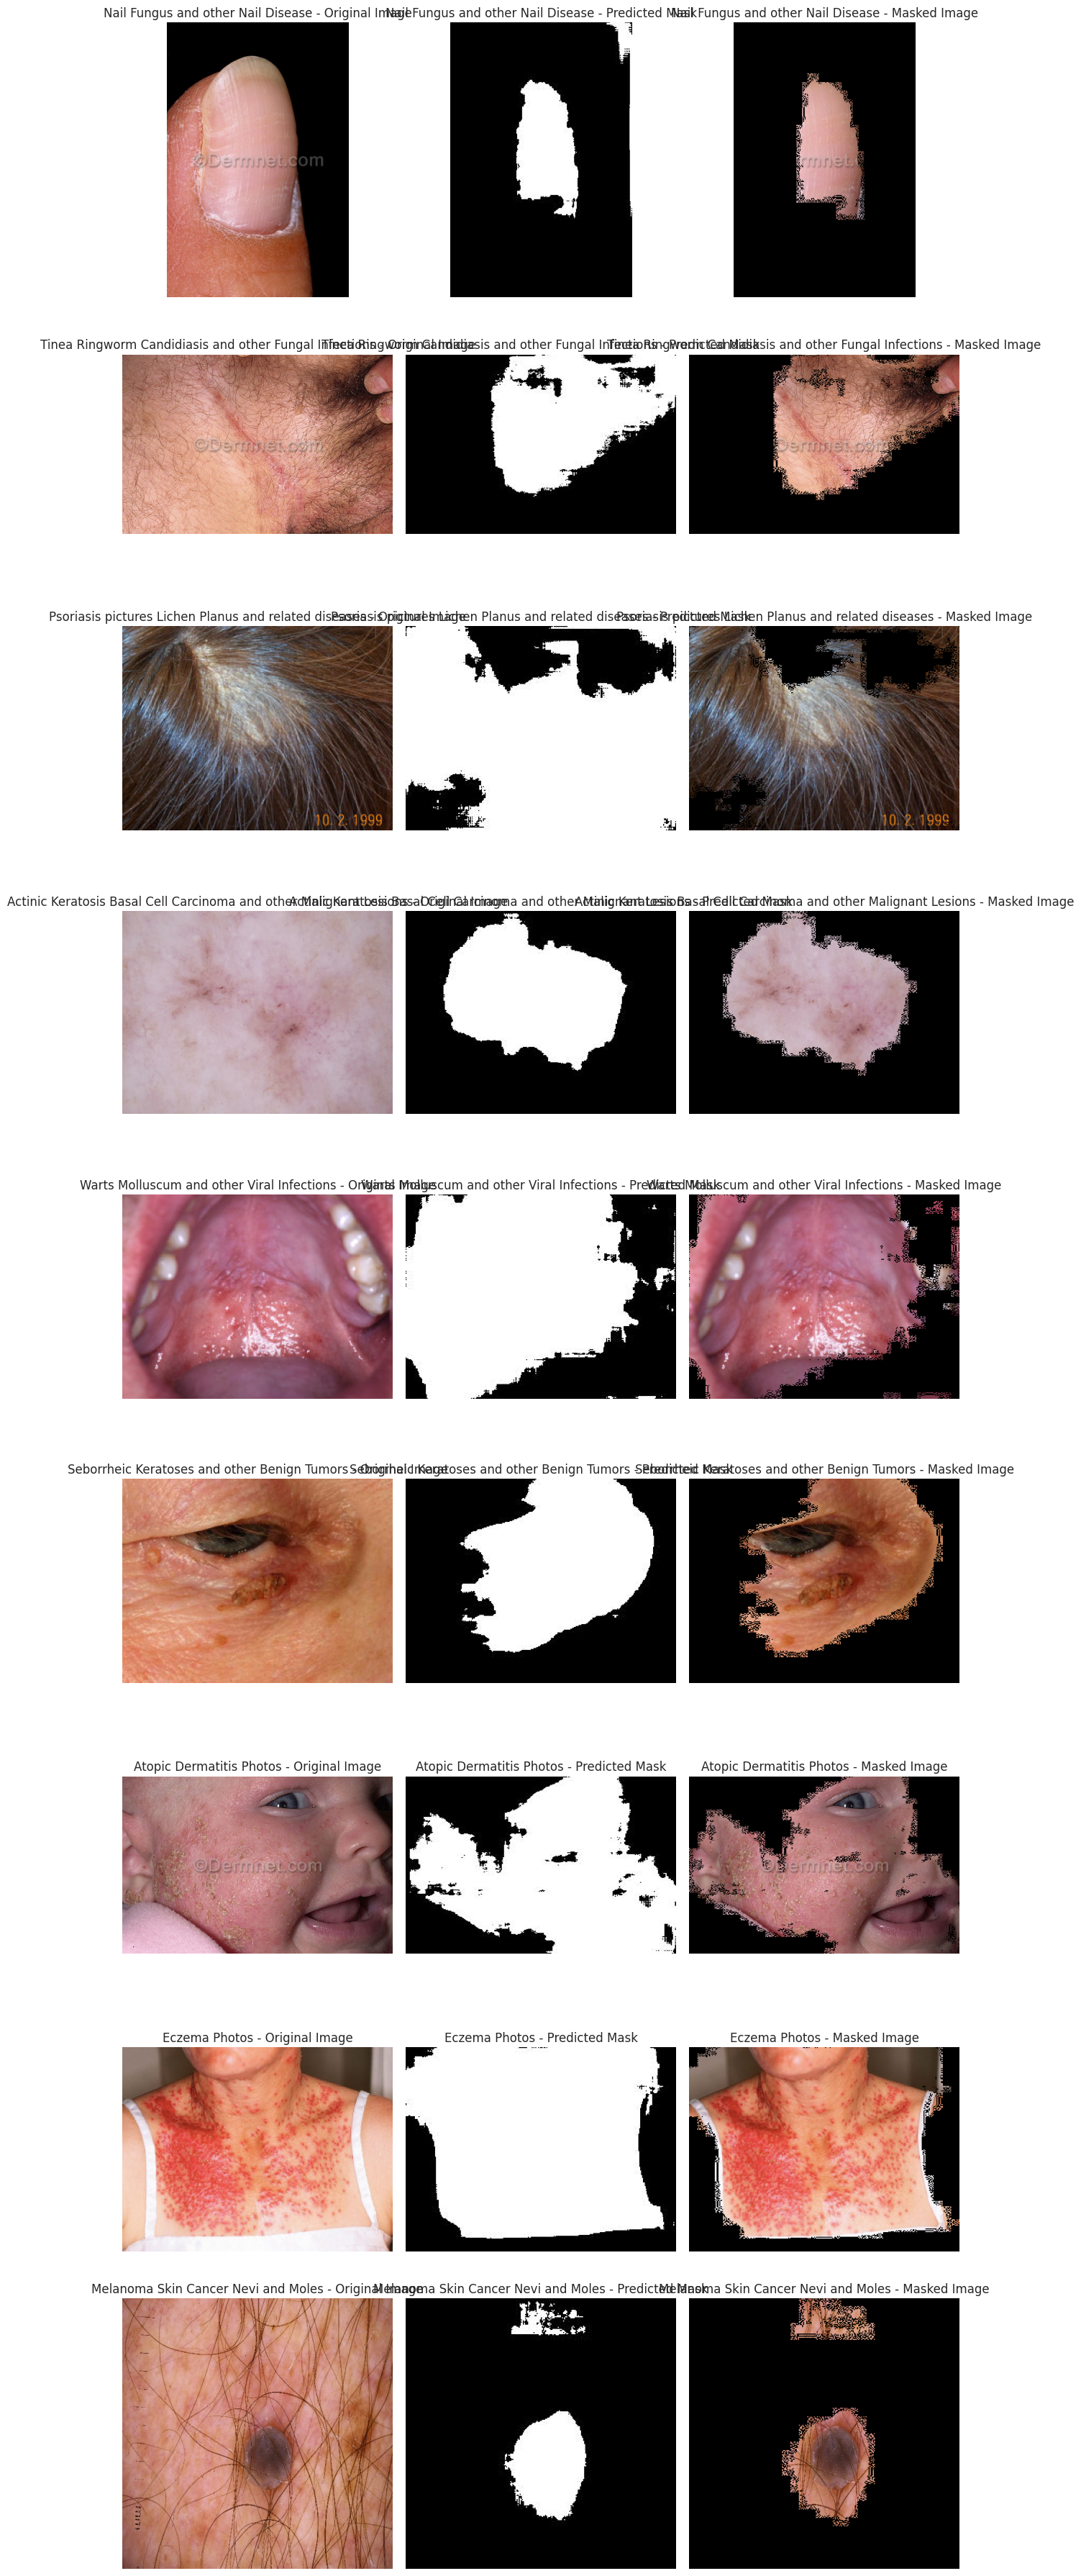

In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def get_images_with_mask(image_path, mask_path):
    """
    Reads the original image and mask and applies the mask to the image.
    """
    original_image = np.array(Image.open(image_path))
    mask_image = np.array(Image.open(mask_path))

    # Resize mask to match original image dimensions
    mask_image = np.array(Image.fromarray(mask_image).resize(original_image.shape[:2][::-1], Image.NEAREST))

    # Ensure mask is binary (0 or 1)
    if len(mask_image.shape) > 2:
        mask_image = mask_image[..., 0]  # Use the first channel if mask is RGB-like

    # Mask remains as is (white visible, black transparent)
    masked_image = original_image.copy()
    masked_image[mask_image == 0] = [0, 0, 0]  # Set black regions of the mask to black

    return {
        "Original Image": original_image,
        "Predicted Mask": mask_image,
        "Masked Image": masked_image,
    }

def visualize_images(image_dir, mask_dir):
    """
    Visualizes one image from each subfolder along with its mask and masked image side-by-side.
    """
    # Get all subfolders in the train directory
    subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

    num_cols = 3  # Original Image, Mask, and Masked Image
    fig, axs = plt.subplots(len(subfolders), num_cols, figsize=(num_cols * 4, len(subfolders) * 4))

    for i, subfolder in enumerate(subfolders):
        # Get paths for the current subfolder
        subfolder_path = os.path.join(image_dir, subfolder)
        mask_subfolder_path = os.path.join(mask_dir, subfolder)

        if not os.path.exists(mask_subfolder_path):
            print(f"Mask subfolder for '{subfolder}' does not exist. Skipping...")
            continue

        # Get the first image in the subfolder
        image_files = os.listdir(subfolder_path)
        if not image_files:
            print(f"No images found in subfolder '{subfolder}'. Skipping...")
            continue

        image_file = image_files[0]  # Pick the first image in the subfolder
        image_path = os.path.join(subfolder_path, image_file)
        mask_path = os.path.join(mask_subfolder_path, image_file)

        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Get the images for visualization
            images = get_images_with_mask(image_path, mask_path)

            # Plot the images side by side
            for j, (title, image) in enumerate(images.items()):
                axs[i, j].imshow(image, cmap="gray" if title == "Predicted Mask" else None)
                axs[i, j].set_title(f"{subfolder} - {title}")
                axs[i, j].axis("off")
        else:
            print(f"Image or mask not found for '{image_file}' in subfolder '{subfolder}'. Skipping...")

    plt.tight_layout()
    plt.show()

# Directories for images and masks
image_directory = "/kaggle/working/temp_train"
mask_directory = "/kaggle/working/predicted_masks/train"

visualize_images(image_directory, mask_directory)


In [91]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# def get_images_with_mask(image_path, mask_path):
#     """
#     Reads the original image and mask and applies the mask to the image.
#     """
#     original_image = np.array(Image.open(image_path))
#     mask_image = np.array(Image.open(mask_path))

#     # Resize mask to match original image dimensions
#     mask_image = np.array(Image.fromarray(mask_image).resize(original_image.shape[:2][::-1], Image.NEAREST))

#     # Ensure mask is binary (0 or 1)
#     if len(mask_image.shape) > 2:
#         mask_image = mask_image[..., 0]  # Use the first channel if mask is RGB-like

#     # Mask remains as is (white visible, black transparent)
#     masked_image = original_image.copy()
#     masked_image[mask_image == 0] = [0, 0, 0]  # Set black regions of the mask to black

#     return {
#         "Original Image": original_image,
#         "Predicted Mask": mask_image,
#         "Masked Image": masked_image,
#     }

# def visualize_images(image_dir, mask_dir, num_subjects=3):
#     """
#     Visualizes a subset of images, masks, and masked images side-by-side.
#     """
#     # Get subfolders in the train directory
#     subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]
#     subfolders = subfolders[:num_subjects]  # Limit to num_subjects for visualization

#     num_cols = 3  # Original Image, Mask, and Masked Image
#     fig, axs = plt.subplots(len(subfolders), num_cols, figsize=(num_cols * 4, len(subfolders) * 4))

#     for i, subfolder in enumerate(subfolders):
#         # Get the first image in the subfolder
#         subfolder_path = os.path.join(image_dir, subfolder)
#         mask_subfolder_path = os.path.join(mask_dir, subfolder)

#         if not os.path.exists(mask_subfolder_path):
#             print(f"Mask subfolder for '{subfolder}' does not exist. Skipping...")
#             continue

#         image_files = os.listdir(subfolder_path)
#         if not image_files:
#             print(f"No images found in subfolder '{subfolder}'. Skipping...")
#             continue

#         image_file = image_files[0]
#         image_path = os.path.join(subfolder_path, image_file)
#         mask_path = os.path.join(mask_subfolder_path, image_file)

#         if os.path.exists(image_path) and os.path.exists(mask_path):
#             # Get the images for visualization
#             images = get_images_with_mask(image_path, mask_path)

#             # Plot the images side by side
#             for j, (title, image) in enumerate(images.items()):
#                 axs[i, j].imshow(image, cmap="gray" if title == "Predicted Mask" else None)
#                 axs[i, j].set_title(title)
#                 axs[i, j].axis("off")
#         else:
#             print(f"Image or mask not found for '{image_file}'. Skipping...")

#     plt.tight_layout()
#     plt.show()

# # Directories for images and masks
# image_directory = "/kaggle/working/temp_train"
# mask_directory = "/kaggle/working/predicted_masks/train"

# visualize_images(image_directory, mask_directory, num_subjects=9)


## Saving the masked images for easy usage - train and test both

In [92]:
import os
import numpy as np
from PIL import Image

def create_masked_images(image_dir, mask_dir, output_dir):
    """
    Creates and saves masked images by applying masks to corresponding original images.
    The output directory will have the same subfolder structure as the input image directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create the output directory if it doesn't exist

    # Iterate through subfolders in the image directory
    subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

    for subfolder in subfolders:
        # Paths for the current subfolder
        subfolder_path = os.path.join(image_dir, subfolder)
        mask_subfolder_path = os.path.join(mask_dir, subfolder)
        output_subfolder_path = os.path.join(output_dir, subfolder)

        if not os.path.exists(mask_subfolder_path):
            print(f"Mask subfolder for '{subfolder}' does not exist. Skipping...")
            continue

        # Create the subfolder in the output directory
        if not os.path.exists(output_subfolder_path):
            os.makedirs(output_subfolder_path)

        # Process images in the subfolder
        image_files = os.listdir(subfolder_path)
        for image_file in image_files:
            image_path = os.path.join(subfolder_path, image_file)
            mask_path = os.path.join(mask_subfolder_path, image_file)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                # Read the original image and mask
                original_image = np.array(Image.open(image_path))
                mask_image = np.array(Image.open(mask_path))

                # Resize mask to match the original image dimensions
                mask_image = np.array(Image.fromarray(mask_image).resize(original_image.shape[:2][::-1], Image.NEAREST))

                # Ensure mask is binary (0 or 1)
                if len(mask_image.shape) > 2:
                    mask_image = mask_image[..., 0]  # Use the first channel if mask is RGB-like

                # Create the masked image
                masked_image = original_image.copy()
                masked_image[mask_image == 0] = [0, 0, 0]  # Set black regions of the mask to black

                # Save the masked image to the output directory
                output_path = os.path.join(output_subfolder_path, image_file)
                Image.fromarray(masked_image).save(output_path)
                print(f"Saved masked image: {output_path}")
            else:
                print(f"Image or mask not found for '{image_file}' in subfolder '{subfolder}'. Skipping...")

# Directories for input and output
image_directory = "/kaggle/working/temp_train"
mask_directory = "/kaggle/working/predicted_masks/train"
output_directory = "/kaggle/working/masked_images/train"

# Create and save masked images
create_masked_images(image_directory, mask_directory, output_directory)

Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/clubbing-7.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/distal-subungual-onychomycosis-153.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/alopecia-areata-35.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/distal-subungual-onychomycosis-129.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/distal-subungual-onychomycosis-84.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/acute-paronychia-3.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/distal-subungual-onychomycosis-24.jpg
Saved masked image: /kaggle/working/masked_images/train/Nail Fungus and other Nail Disease/alopecia-areata-66.jpg
Saved masked image: /kaggle/workin

In [93]:
image_directory = "/kaggle/working/temp_test"
mask_directory = "/kaggle/working/predicted_masks/test"
output_directory = "/kaggle/working/masked_images/test"

create_masked_images(image_directory, mask_directory, output_directory)

Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/alopecia-areata-94.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/acute-paronychia-2.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/acute-paronychia-7.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/alopecia-areata-19.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/alopecia-areata-89.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/alopecia-areata-55.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/acute-paronychia-23.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/chronic-paronychia-2.jpg
Saved masked image: /kaggle/working/masked_images/test/Nail Fungus and other Nail Disease/bea

## Loading + Processing the masked images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths for masked images
masked_train_dir = "/kaggle/working/masked_images/train"
masked_test_dir = "/kaggle/working/masked_images/test"

# Image dimensions
IMG_SIZE = 256

# Data generator with preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Train generator for masked images
masked_train_generator = datagen.flow_from_directory(
    masked_train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Test generator for masked images
masked_test_generator = datagen.flow_from_directory(
    masked_test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Output information about the generators
print(f"Total masked images in train generator: {len(masked_train_generator.filenames)}")
print(f"Total masked images in test generator: {len(masked_test_generator.filenames)}")


Found 2700 images belonging to 9 classes.
Found 450 images belonging to 9 classes.
Total masked images in train generator: 2700
Total masked images in test generator: 450


## Model 1: InceptionResNetV2

In [95]:
from keras import Model
from keras import optimizers
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D,Dense

model_i = Sequential()
model_i.add( tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights= "imagenet", input_shape=(256, 256, 3)))

model_i.add(GlobalAveragePooling2D())
model_i.add(Dense(9, activation="softmax"))
model_i.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [96]:
import tensorflow as tf

# Compile the model
model_i.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC')  # Include ROC-AUC metric
    ]
)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history_i = model_i.fit(masked_train_generator,validation_data=masked_test_generator,epochs=10,shuffle=True)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/85 ━━━━━━━━━━━━━━━━━━━━ 10s 841ms/step - accuracy: 0.3666 - loss: 1.7331 - precision: 0.6145 - recall: 0.1828 - roc_auc: 0.7901

I0000 00:00:1733910333.461703     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 32 bytes spill stores, 32 bytes spill loads



85/85 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.3823 - loss: 1.6910 - precision: 0.6260 - recall: 0.1963 - roc_auc: 0.8011 - val_accuracy: 0.1689 - val_loss: 7.9021 - val_precision: 0.2214 - val_recall: 0.0689 - val_roc_auc: 0.5558
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 73s 855ms/step - accuracy: 0.6220 - loss: 1.0813 - precision: 0.8030 - recall: 0.4678 - roc_auc: 0.9244 - val_accuracy: 0.2267 - val_loss: 3.0775 - val_precision: 0.3049 - val_recall: 0.1511 - val_roc_auc: 0.5909
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 74s 864ms/step - accuracy: 0.6618 - loss: 0.9278 - precision: 0.8064 - recall: 0.5356 - roc_auc: 0.9452 - val_accuracy: 0.1200 - val_loss: 3.4507 - val_precision: 0.1049 - val_recall: 0.0378 - val_roc_auc: 0.5291
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 74s 864ms/step - accuracy: 0.7098 - loss: 0.7927 - precision: 0.8136 - recall: 0.6045 - roc_auc: 0.9596 - val_accuracy: 0.2356 - val_loss: 4.6418 - val_precision: 0.2961 - val_recall: 0.1356 - val_roc_auc: 0.6200
Epoch 5/1

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 821ms/step


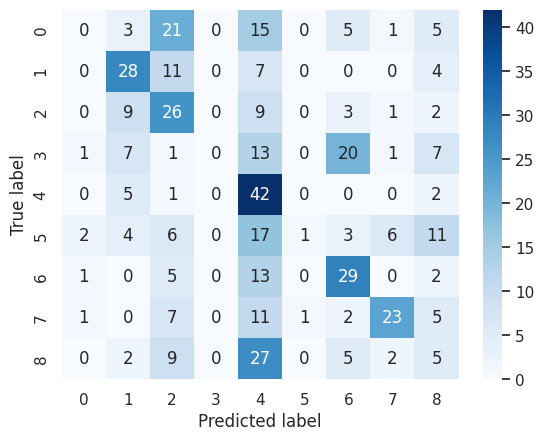

In [98]:
predictions = model_i.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [99]:
predictions = model_i.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step
                                                                    precision    recall  f1-score   support

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        50
                                          Atopic Dermatitis Photos       0.48      0.56      0.52        50
                                                     Eczema Photos       0.30      0.52      0.38        50
                               Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00        50
                                Nail Fungus and other Nail Disease       0.27      0.84      0.41        50
             Psoriasis pictures Lichen Planus and related diseases       0.50      0.02      0.04        50
                      Seborrheic Keratoses and other Benign Tumors       0.43      0.58      0.50        50
            Tinea Ringworm Candidiasis and other Fungal Infections       0.68      0.46      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


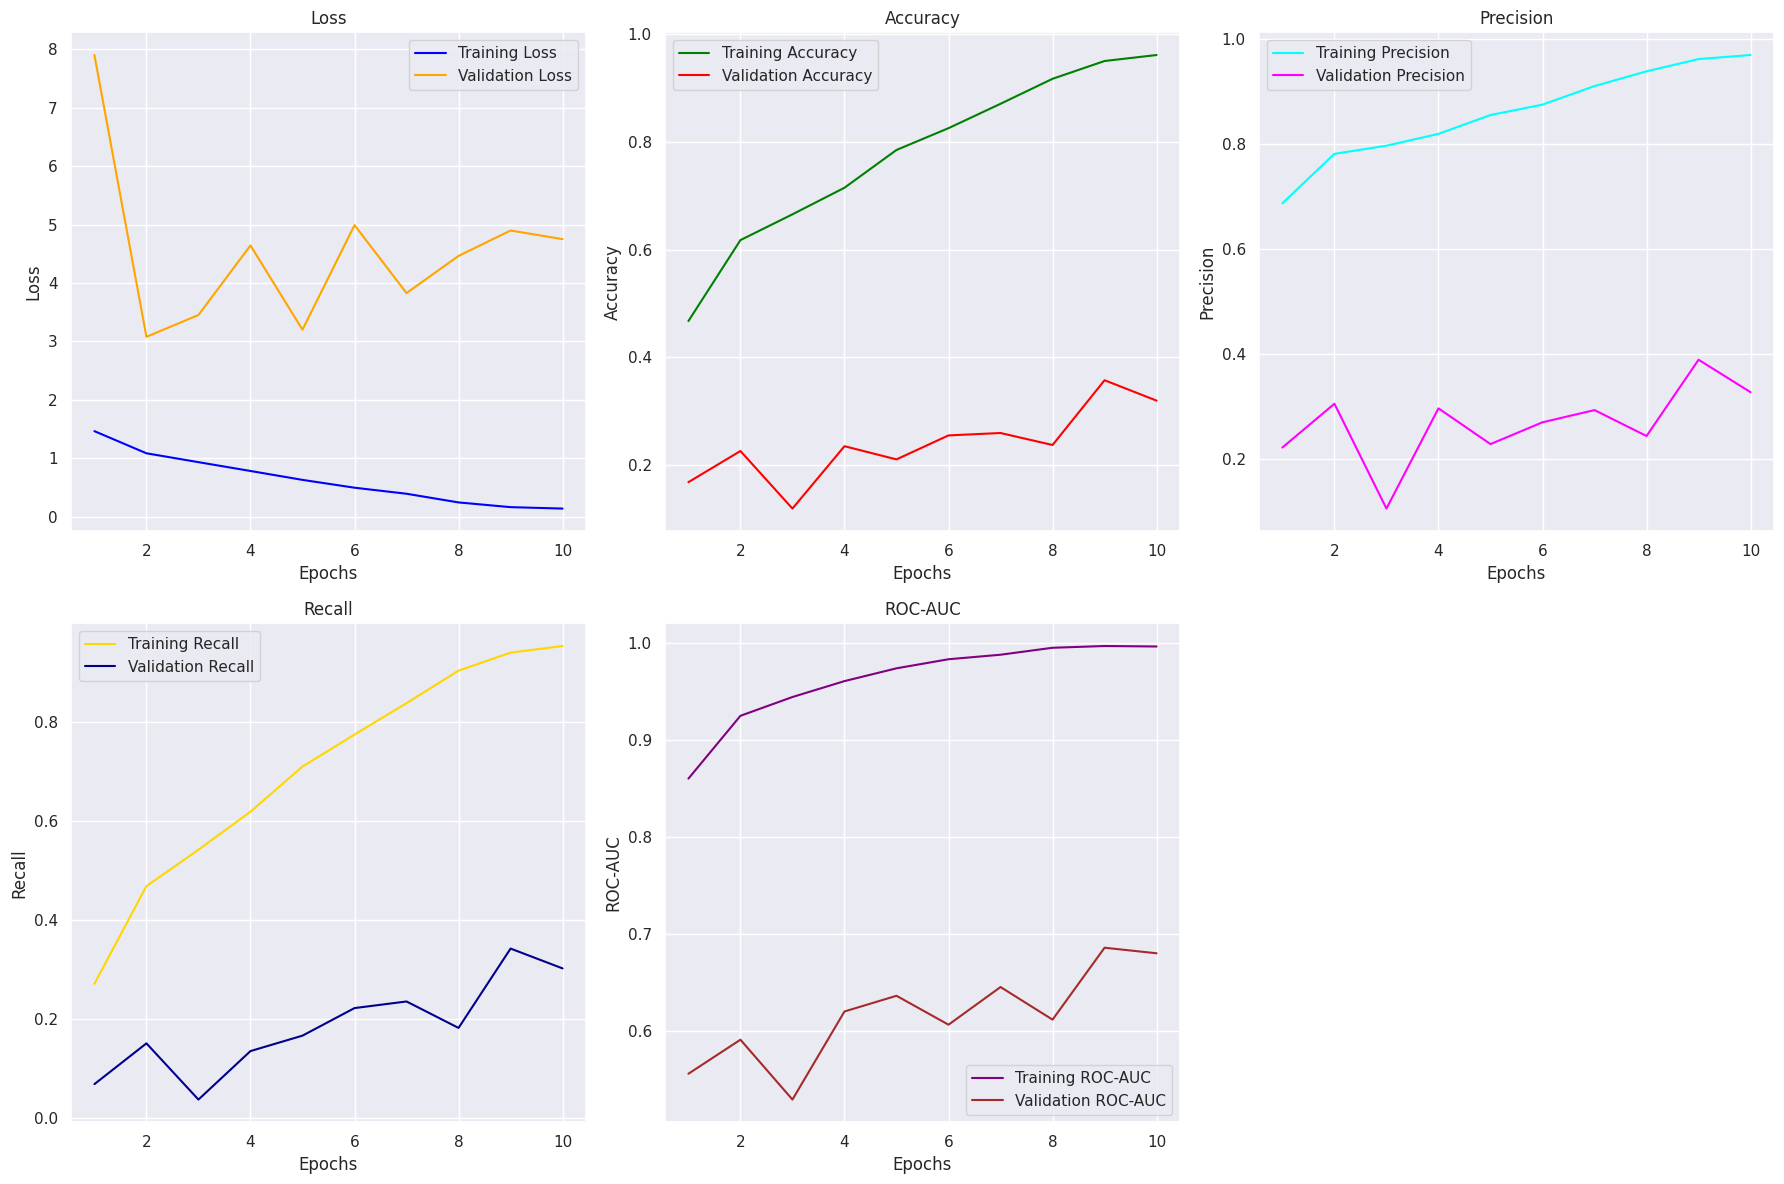

In [100]:
import matplotlib.pyplot as plt

def plot_training_metrics_with_details(history):
    """
    Plots training and validation metrics including loss, accuracy, precision, recall, and ROC-AUC.
    """
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(18, 12))

    # Plot Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Precision
    if 'precision' in history.history and 'val_precision' in history.history:
        plt.subplot(2, 3, 3)
        plt.plot(epochs, history.history['precision'], label='Training Precision', color='cyan')
        plt.plot(epochs, history.history['val_precision'], label='Validation Precision', color='magenta')
        plt.title('Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Plot Recall
    if 'recall' in history.history and 'val_recall' in history.history:
        plt.subplot(2, 3, 4)
        plt.plot(epochs, history.history['recall'], label='Training Recall', color='gold')
        plt.plot(epochs, history.history['val_recall'], label='Validation Recall', color='darkblue')
        plt.title('Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    # Plot ROC-AUC
    if 'roc_auc' in history.history and 'val_roc_auc' in history.history:
        plt.subplot(2, 3, 5)
        plt.plot(epochs, history.history['roc_auc'], label='Training ROC-AUC', color='purple')
        plt.plot(epochs, history.history['val_roc_auc'], label='Validation ROC-AUC', color='brown')
        plt.title('ROC-AUC')
        plt.xlabel('Epochs')
        plt.ylabel('ROC-AUC')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the updated function
plot_training_metrics_with_details(history_i)

## Model 2: DenseNet

In [110]:
model_ii.build(input_shape=(None, 256, 256, 3))

In [111]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet201

# Create the DenseNet-based model
model_ii = Sequential()

# Add DenseNet base model
model_ii.add(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
))

# Add Global Average Pooling layer
model_ii.add(GlobalAveragePooling2D())

# Add output layer for 9 classes
model_ii.add(Dense(9, activation="softmax"))

# Display model summary
model_ii.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [112]:
import tensorflow as tf

# Compile the model
model_ii.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC')  # Include ROC-AUC metric
    ]
)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history_ii = model_ii.fit(masked_train_generator,validation_data=masked_test_generator,epochs=10,shuffle=True)

Epoch 1/10
43/85 ━━━━━━━━━━━━━━━━━━━━ 28s 680ms/step - accuracy: 0.3204 - loss: 1.9505 - precision: 0.5500 - recall: 0.1957 - roc_auc: 0.7491

I0000 00:00:1733912122.388509     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion', 4 bytes spill stores, 4 bytes spill loads



85/85 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.3648 - loss: 1.8099 - precision: 0.5894 - recall: 0.2131 - roc_auc: 0.7835 - val_accuracy: 0.1889 - val_loss: 7.1982 - val_precision: 0.1911 - val_recall: 0.1622 - val_roc_auc: 0.5625
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 58s 676ms/step - accuracy: 0.5785 - loss: 1.2051 - precision: 0.7804 - recall: 0.3827 - roc_auc: 0.9060 - val_accuracy: 0.2022 - val_loss: 3.5122 - val_precision: 0.2260 - val_recall: 0.1467 - val_roc_auc: 0.6174
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 55s 641ms/step - accuracy: 0.5865 - loss: 1.1188 - precision: 0.7817 - recall: 0.4267 - roc_auc: 0.9198 - val_accuracy: 0.1689 - val_loss: 7.0908 - val_precision: 0.1693 - val_recall: 0.1444 - val_roc_auc: 0.5690
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 56s 655ms/step - accuracy: 0.6458 - loss: 1.0272 - precision: 0.7914 - recall: 0.4826 - roc_auc: 0.9316 - val_accuracy: 0.1778 - val_loss: 3.9522 - val_precision: 0.1851 - val_recall: 0.1267 - val_roc_auc: 0.5651
Epoch 5/1

15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step 


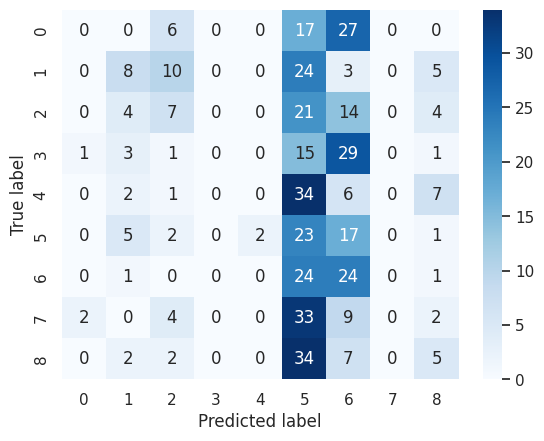

In [115]:
predictions = model_ii.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [116]:
predictions = model_ii.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
                                                                    precision    recall  f1-score   support

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        50
                                          Atopic Dermatitis Photos       0.32      0.16      0.21        50
                                                     Eczema Photos       0.21      0.14      0.17        50
                               Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00        50
                                Nail Fungus and other Nail Disease       0.00      0.00      0.00        50
             Psoriasis pictures Lichen Planus and related diseases       0.10      0.46      0.17        50
                      Seborrheic Keratoses and other Benign Tumors       0.18      0.48      0.26        50
            Tinea Ringworm Candidiasis and other Fungal Infections       0.00      0.00      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


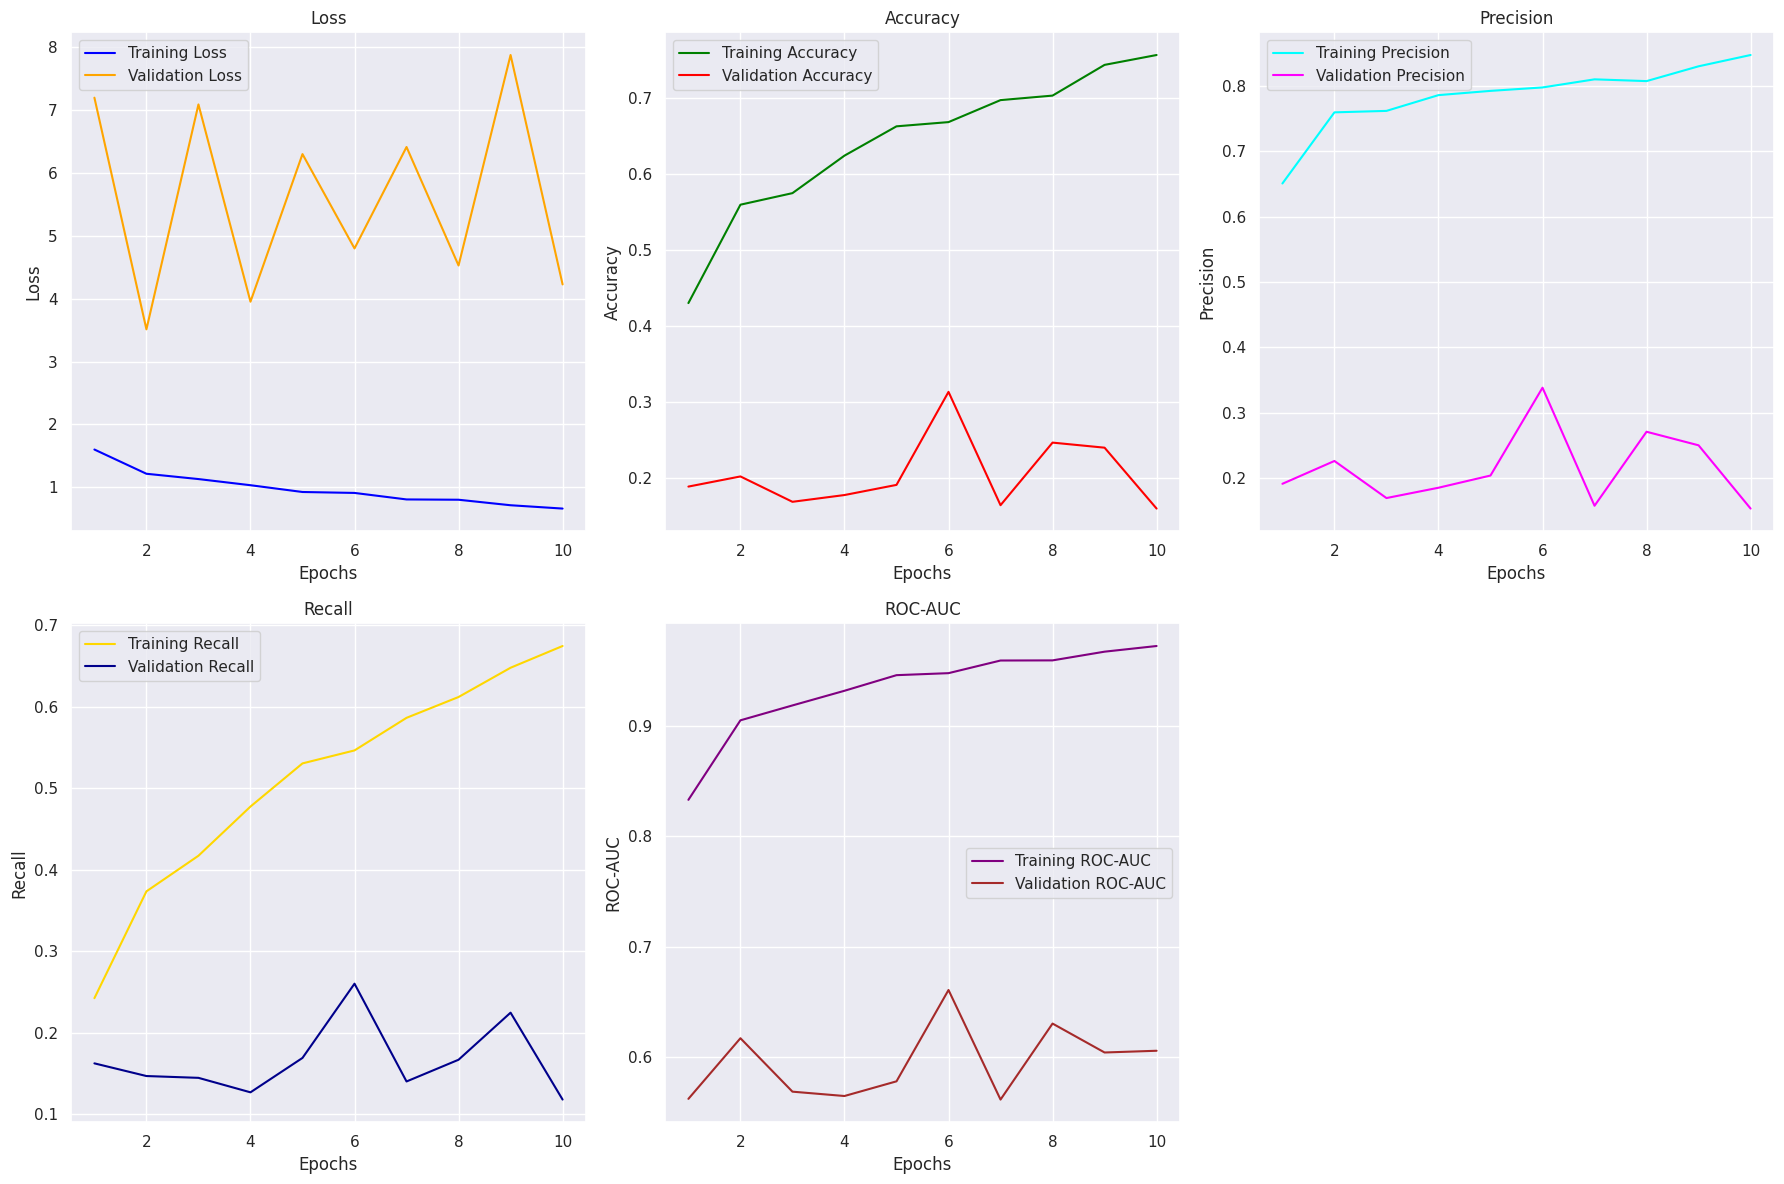

In [117]:
plot_training_metrics_with_details(history_ii)

## Model 3: MobileNetV2

In [118]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2

# Create the MobileNet-based model
model_iii = Sequential()

# Add MobileNet base model
model_iii.add(MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
))

# Add Global Average Pooling layer
model_iii.add(GlobalAveragePooling2D())

# Add output layer for 9 classes
model_iii.add(Dense(9, activation="softmax"))

# Display model summary
model_iii.summary()

/tmp/ipykernel_23/1865223855.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_iii.add(MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [119]:
import tensorflow as tf

# Compile the model
model_iii.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC')  # Include ROC-AUC metric
    ]
)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history_iii = model_iii.fit(masked_train_generator,validation_data=masked_test_generator,epochs=10,shuffle=True)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 427ms/step - accuracy: 0.4585 - loss: 1.5648 - precision: 0.6415 - recall: 0.3027 - roc_auc: 0.8353 - val_accuracy: 0.1111 - val_loss: 29.5896 - val_precision: 0.1111 - val_recall: 0.1111 - val_roc_auc: 0.4998
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.6402 - loss: 1.0026 - precision: 0.7850 - recall: 0.4958 - roc_auc: 0.9359 - val_accuracy: 0.1267 - val_loss: 17.3617 - val_precision: 0.1250 - val_recall: 0.1244 - val_roc_auc: 0.5094
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.7095 - loss: 0.8109 - precision: 0.8355 - recall: 0.5981 - roc_auc: 0.9580 - val_accuracy: 0.1111 - val_loss: 39.2539 - val_precision: 0.1111 - val_recall: 0.1111 - val_roc_auc: 0.5000
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.7513 - loss: 0.7139 - precision: 0.8509 - recall: 0.6404 - roc_auc: 0.9679 - val_accuracy: 0.1133 - val_loss: 21.5574 - val_precision: 0.1133 - val_recall: 0.1133 - val_roc_auc:

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step


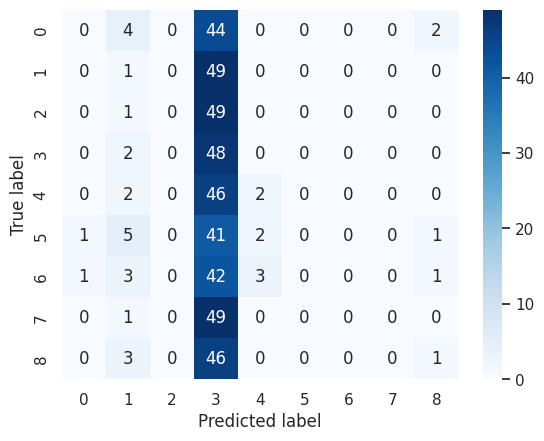

In [120]:
predictions = model_iii.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [121]:
predictions = model_iii.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
                                                                    precision    recall  f1-score   support

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        50
                                          Atopic Dermatitis Photos       0.05      0.02      0.03        50
                                                     Eczema Photos       0.00      0.00      0.00        50
                               Melanoma Skin Cancer Nevi and Moles       0.12      0.96      0.21        50
                                Nail Fungus and other Nail Disease       0.29      0.04      0.07        50
             Psoriasis pictures Lichen Planus and related diseases       0.00      0.00      0.00        50
                      Seborrheic Keratoses and other Benign Tumors       0.00      0.00      0.00        50
            Tinea Ringworm Candidiasis and other Fungal Infections       0.00      0.00      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


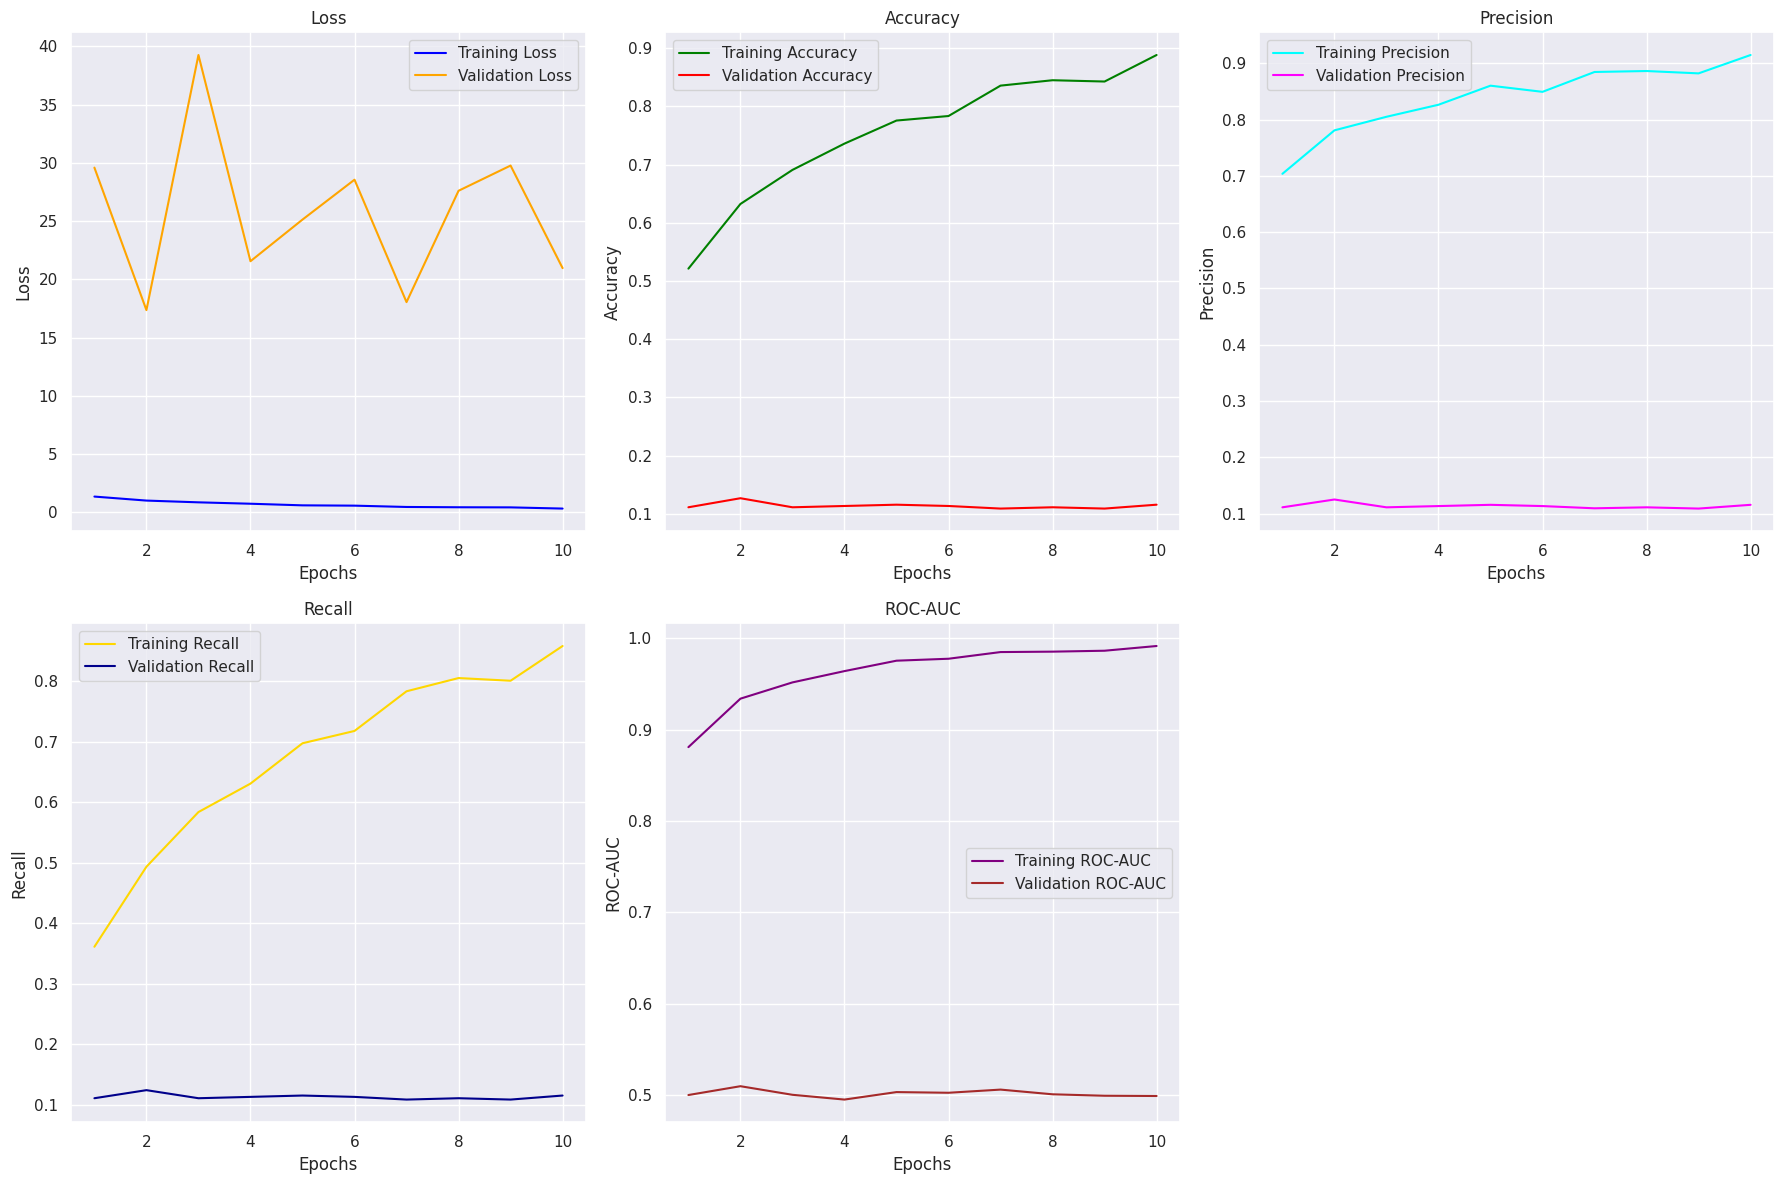

In [122]:
plot_training_metrics_with_details(history_iii)

## Model 4: EfficientNet

In [123]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import EfficientNetB0

# Create the EfficientNet-based model
model_iv = Sequential()

# Add EfficientNet base model
model_iv.add(EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
))

# Add Global Average Pooling layer
model_iv.add(GlobalAveragePooling2D())

# Add output layer for 9 classes
model_iv.add(Dense(9, activation="softmax"))

# Display model summary
model_iv.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [124]:
import tensorflow as tf

# Compile the model
model_iv.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC')  # Include ROC-AUC metric
    ]
)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history_iv = model_iv.fit(masked_train_generator,validation_data=masked_test_generator,epochs=10,shuffle=True)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 130s 731ms/step - accuracy: 0.4684 - loss: 1.4634 - precision: 0.7347 - recall: 0.2901 - roc_auc: 0.8457 - val_accuracy: 0.1111 - val_loss: 2.5985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4997
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.7234 - loss: 0.7943 - precision: 0.8388 - recall: 0.6038 - roc_auc: 0.9603 - val_accuracy: 0.1089 - val_loss: 2.4216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5004
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.7856 - loss: 0.6101 - precision: 0.8656 - recall: 0.7028 - roc_auc: 0.9758 - val_accuracy: 0.1111 - val_loss: 2.8639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5004
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.8819 - loss: 0.3673 - precision: 0.9115 - recall: 0.8413 - roc_auc: 0.9906 - val_accuracy: 0.1044 - val_loss: 2.5902 - val_precision: 0.4000 - val_recall: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step


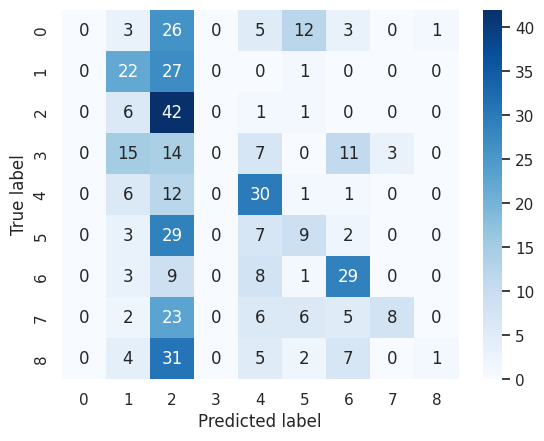

In [125]:
predictions = model_iv.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [126]:
predictions = model_iv.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
                                                                    precision    recall  f1-score   support

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        50
                                          Atopic Dermatitis Photos       0.34      0.44      0.39        50
                                                     Eczema Photos       0.20      0.84      0.32        50
                               Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00        50
                                Nail Fungus and other Nail Disease       0.43      0.60      0.50        50
             Psoriasis pictures Lichen Planus and related diseases       0.27      0.18      0.22        50
                      Seborrheic Keratoses and other Benign Tumors       0.50      0.58      0.54        50
            Tinea Ringworm Candidiasis and other Fungal Infections       0.73      0.16      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


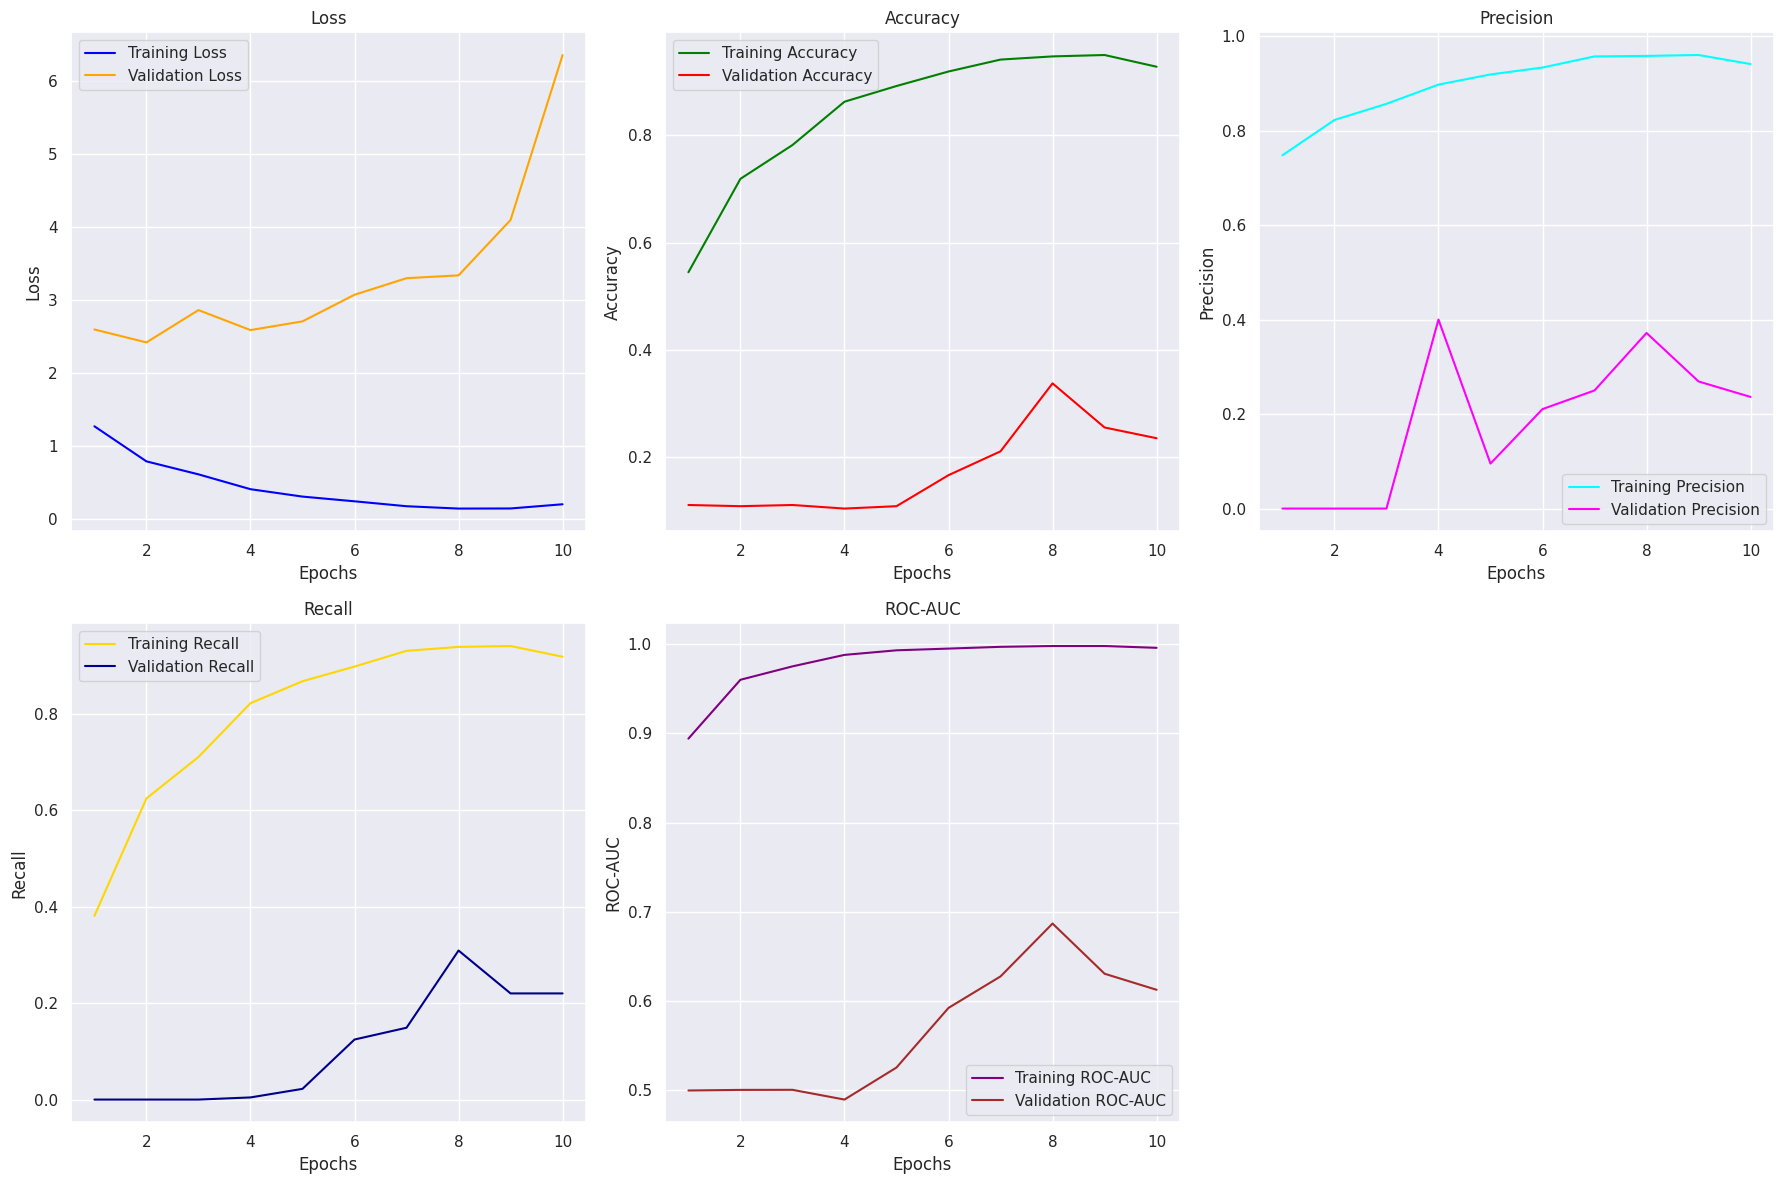

In [127]:
plot_training_metrics_with_details(history_iv)